In [1]:
library('tidyverse')
library('readxl')
library('ggrepel')

library('limma')
library('edgeR')

org_opts <- options()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
metadata <-
    read_csv('clinical_metadata.csv')

metadata

Rows: 11 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Specimen ID, Sample id, primary/recurrence, central/conventional, M...
dbl (2): age, grade

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Specimen ID,Sample id,age,primary/recurrence,grade,central/conventional,Margin
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0-20-100-00479,S10-479,NA,primary,3,central,M0
1-20-140-11208,S14-11208,69,primary,3,central,M1
1-20-150-16380,S15-16380,59,recurrence,2,central,M0
1-20-140-09996,S14-9996,103,primary,3,central,M2
1- S-17-0004703,S17-4703,44,primary,2,conventional,NA
NMS22-28934,NMS22-28934,50,primary,3,conventional,M0
0-20-080-25548,S08-25548,62,primary,NA,conventional,M2
NMS22-13453,NMS22-13453,50,primary,2,NA,NA
NMS23-00471,NMS23-471,56,primary,2,conventional,M0


In [3]:
samples_to_include <-
    metadata %>%
    drop_na(`grade`) %>%
    pull(`Sample id`)

samples_to_include

[1] "S10-479"     "S14-11208"   "S15-16380"   "S14-9996"    "S17-4703"   
 [6] "NMS22-28934" "NMS22-13453" "NMS23-471"   "NMS23-1947"  "S18-6943"

In [4]:
gene_exp <-
    read_xlsx('Chondrosarcoma Nanostring 12082023.xlsx', sheet='Chondrosarcoma Raw data ') %>%
    drop_na(`Probe Name`) %>%
    select(-`Standard_12.RCC`, -c(`NS Probe ID`:`Class Date`)) %>%
    mutate(across(`NMS22-13453_08.RCC`:`S18-6943_07.RCC`, parse_double))

gene_exp %>%
    head()

Probe Name,Annotation,Accession #,Avg Count,Min Count,Max Count,%CV,NMS22-13453_08.RCC,NMS22-28934_09.RCC,NMS23-1947_11.RCC,NMS23-471_10.RCC,S08-25548_01.RCC,S10-479_02.RCC,S14-11208_04.RCC,S14-9996_03.RCC,S15-16380_05.RCC,S17-4703_06.RCC,S18-6943_07.RCC
<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2M,NA,NM_000014.4,8076.17,1517,17526,69.37,12739,17526,8575,6694,7450,1517,2508,3063,12098,16744,5997
ACVR1C,NA,NM_145259.2,158.17,11,1539,275.51,17,25,20,21,22,15,23,11,88,21,96
ADAM12,NA,NM_003474.5,741.08,75,1159,51.41,1159,686,238,954,973,75,1030,552,987,1069,206
ADGRE1,NA,NM_001256252.1,112.58,7,1179,298.37,33,12,12,7,19,23,7,14,9,22,14
ADM,NA,NM_001124.2,315.75,78,1548,127.69,175,145,238,78,1548,151,127,285,251,118,178
ADORA2A,NA,NM_000675.5,126.17,25,1004,219.60,77,34,25,44,79,26,39,26,50,61,49


In [5]:
gene_exp_matrix <-
    gene_exp %>%
    select(
        `gene_symbol`=`Probe Name`,
        `NMS22-13453_08.RCC`:`S18-6943_07.RCC`
    ) %>%
    pivot_longer(
        names_to='Sample id',
        values_to='cnt',
        -`gene_symbol`
    ) %>%
    mutate(
        `Sample id`=str_replace_all(`Sample id`, '_[0-9][0-9].RCC', '')
    ) %>%
    pivot_wider(
        names_from='Sample id',
        values_from='cnt'
    ) %>%
    select(`gene_symbol`, any_of(samples_to_include)) %>%
    (function(x) {
        gene_symbols <- x %>% pull(`gene_symbol`)
        
        x_mtx <- x %>% select(-`gene_symbol`) %>% as.matrix()
        rownames(x_mtx) <- gene_symbols
        
        x_mtx
    })()

gene_exp_matrix %>%
    head()

,S10-479,S14-11208,S15-16380,S14-9996,S17-4703,NMS22-28934,NMS22-13453,NMS23-471,NMS23-1947,S18-6943
A2M,1517,2508,12098,3063,16744,17526,12739,6694,8575,5997
ACVR1C,15,23,88,11,21,25,17,21,20,96
ADAM12,75,1030,987,552,1069,686,1159,954,238,206
ADGRE1,23,7,9,14,22,12,33,7,12,14
ADM,151,127,251,285,118,145,175,78,238,178
ADORA2A,26,39,50,26,61,34,77,44,25,49


In [6]:
exp_model <-
    metadata %>%
    model.matrix(data=., ~as.factor(`grade`))

exp_model

,(Intercept),as.factor(grade)3
1,1,1
2,1,1
3,1,0
4,1,1
5,1,0
6,1,1
8,1,0
9,1,0
10,1,1
11,1,0


In [7]:
dge <-
    DGEList(gene_exp_matrix) %>%
    calcNormFactors()

keep <- filterByExpr(dge, exp_model)
dge <- dge[keep,, keep.lib.sizes=FALSE]
vdge <- voom(dge, exp_model)
all_fit <- lmFit(vdge, exp_model) %>% eBayes

In [8]:
all_table <-
    topTable(all_fit, adjust.method='fdr', n=nrow(gene_exp_matrix), sort.by='p') %>%
    rownames_to_column(var='gene_symbol') %>%
    as_tibble()

all_table %>%
    head(50)

Removing intercept from test coefficients



gene_symbol,logFC,AveExpr,t,P.Value,adj.P.Val,B
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LIF,1.9191979,8.523538,3.596341,0.002912649,0.7912441,-3.282727
IL1RN,1.6311559,4.810356,3.510903,0.003451660,0.7912441,-3.666963
VCAM1,-1.2821703,8.718161,-3.470097,0.003743508,0.7912441,-3.378207
THBS1,-1.8289985,13.854301,-3.408555,0.004231252,0.7912441,-3.720791
CMKLR1,-1.0630101,9.638235,-3.179515,0.006675724,0.8252633,-3.532830
ATF3,1.6622444,8.603915,3.055661,0.008539573,0.8252633,-3.561971
RSAD2,1.0223235,7.478161,2.878620,0.012127716,0.8252633,-3.696581
IHH,1.9247707,6.445064,2.799714,0.014170340,0.8252633,-3.855892
S100A8,1.9573321,7.862785,2.777383,0.014807077,0.8252633,-3.740664


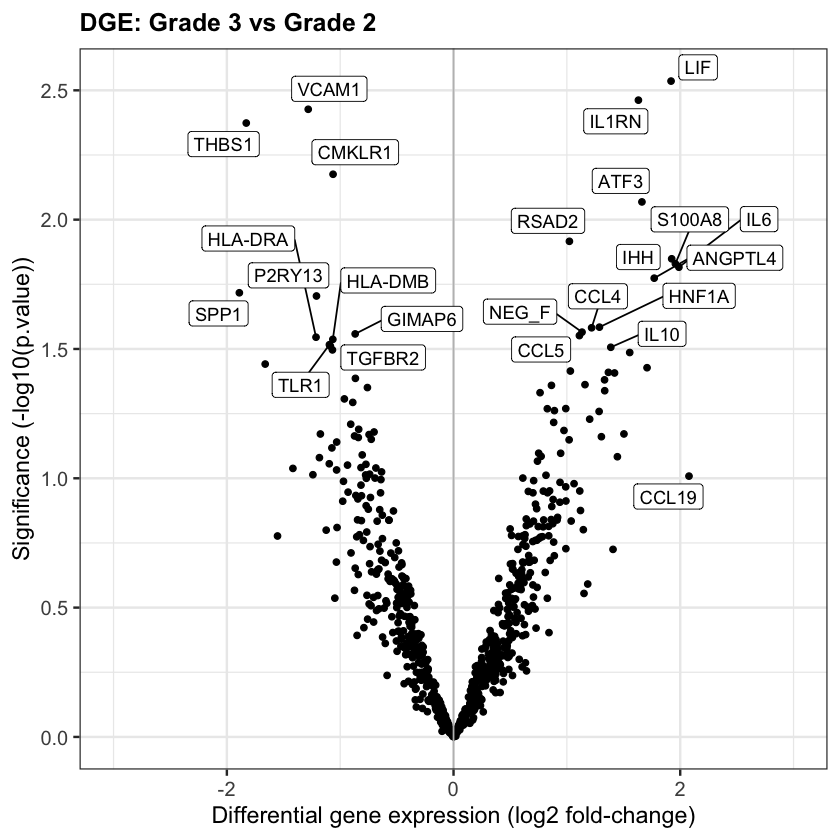

In [12]:
all_table %>%
    mutate(
        `label`=case_when(
            abs(`logFC`) >= 2 ~ str_replace_all(`gene_symbol`, ',.*', ''),
            -log10(`P.Value`) > 1.5 ~ str_replace_all(`gene_symbol`, ',.*', ''),
            TRUE ~ ''
        )
    ) %>%
    ggplot(aes(x=`logFC`, y=-log10(`P.Value`))) +
        geom_point() +
        geom_vline(xintercept=0, color='gray') +
        geom_label_repel(aes(label=`label`), max.overlaps=Inf, force=10) +
        labs(
            x='Differential gene expression (log2 fold-change)',
            y='Significance (-log10(p.value))',
            title='DGE: Grade 3 vs Grade 2'
        ) +
        xlim(-3, 3) +
        theme_bw(base_size=15) +
        theme(
            axis.text=element_text(size=12),
            axis.title=element_text(size=14),
            strip.text.x = element_text(size=15, face="bold"),
            plot.title = element_text(size=15, face="bold")
        )

In [13]:
goi_lst <-
    all_table %>%
    filter(abs(`logFC`) >= 2 | -log10(`P.Value`) > 1.5) %>%
    pull(`gene_symbol`)

goi_lst

[1] "LIF"     "IL1RN"   "VCAM1"   "THBS1"   "CMKLR1"  "ATF3"    "RSAD2"  
 [8] "IHH"     "S100A8"  "IL6"     "ANGPTL4" "SPP1"    "P2RY13"  "HNF1A"  
[15] "CCL4"    "NEG_F"   "GIMAP6"  "CCL5"    "HLA-DRA" "HLA-DMB" "TLR1"   
[22] "TGFBR2"  "IL10"    "CCL19"

Rows: 8624 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gene_symbol, sample
dbl (1): norm_exp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


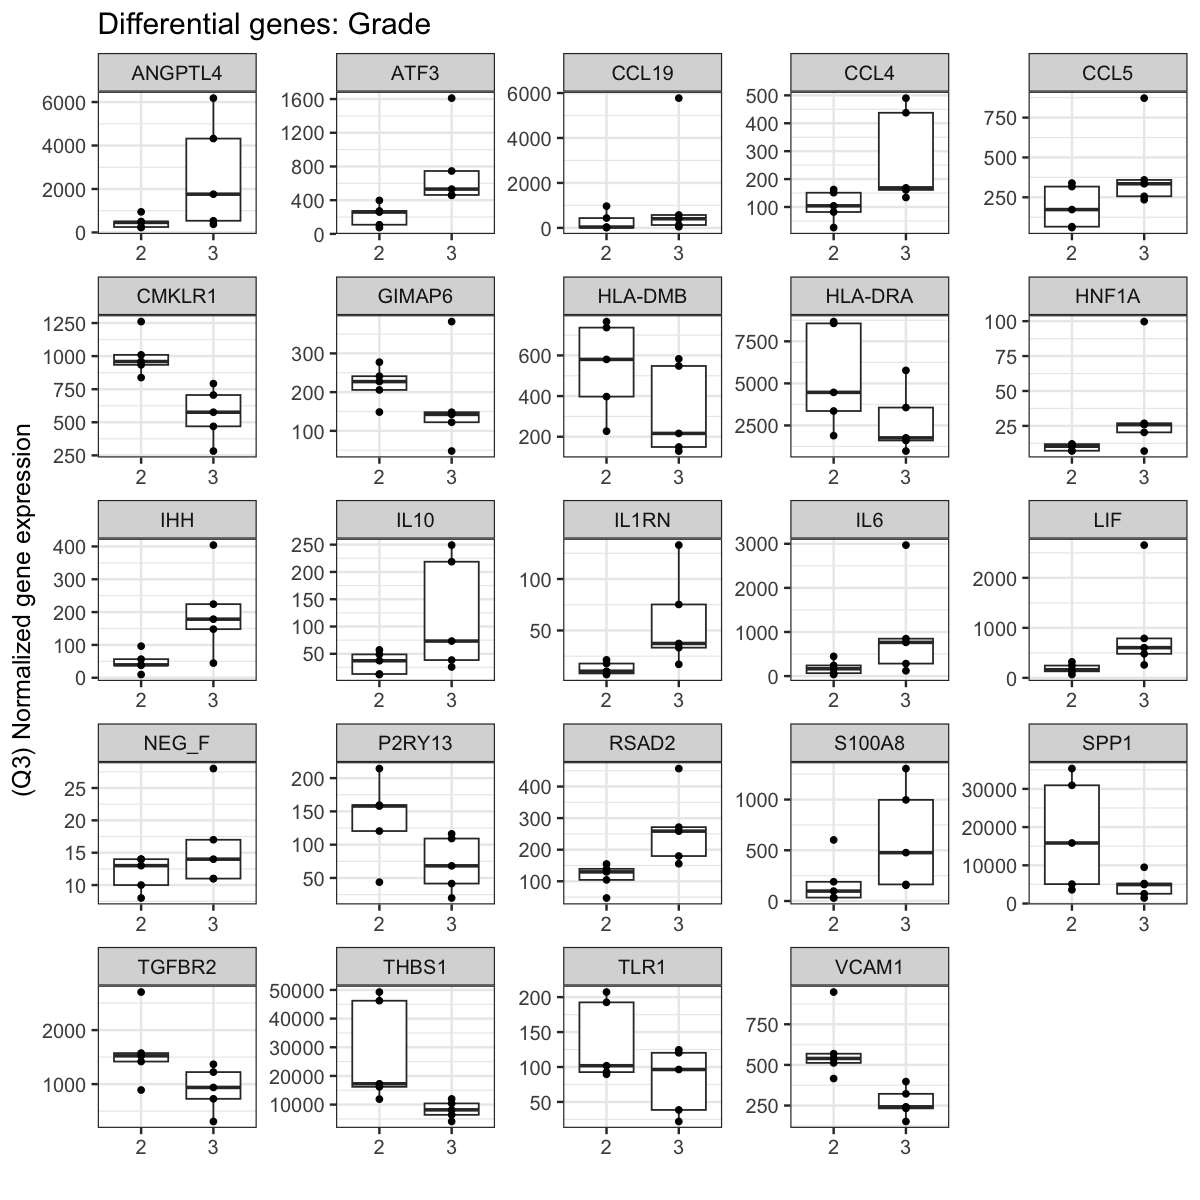

In [14]:
options(repr.plot.width=10, repr.plot.height=10)

read_csv('q3_normalized_exp-long_tbl.csv') %>%
    filter(`gene_symbol` %in% goi_lst) %>%
    rename(`Sample id`=`sample`) %>%
    left_join(metadata, by='Sample id') %>%
    drop_na(`grade`) %>%
    ggplot(aes(x=as.factor(`grade`), y=`norm_exp`)) +
        geom_boxplot(outlier.shape=NA) +
        geom_point() +
        facet_wrap(~`gene_symbol`, scale='free') +
        theme_bw(base_size=15) +
        labs(
            title='Differential genes: Grade',
            x='',
            y='(Q3) Normalized gene expression'
        )

options(org_opts)